# **Final Project:**
---

Authors : Max Ramstad, Elpida Karapepera

Other notebooks used

[Visualizing attention maps](https://colab.research.google.com/drive/1N4wOUsFzKzG_XUuMpszpDFa6mt7ZzO2W?usp=sharing)

[Training ViT base](https://colab.research.google.com/drive/1mu1z-SDgGbJFD1M7jLxVrAzsm6xu3Wta?usp=sharing)

[Training swinv2](https://colab.research.google.com/drive/1Hp7coeC0eGtW1WgfaPoEZuwhpR7rJ7j2?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install torch torchvision tensorboard
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision pillow
!pip install matplotlib
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets transformers
!pip install evaluate
!pip install einops
!pip install torch
!pip install ftfy
!pip install timm
!pip install captum

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-c28w5o7b
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-c28w5o7b
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


# **CLIP model:**
---

## **Version #1 Zero-shot on single image**

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-dj_tevpi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-dj_tevpi
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done

Top predictions:

         churros: 98.63%
     onion_rings: 0.49%
  fried_calamari: 0.37%


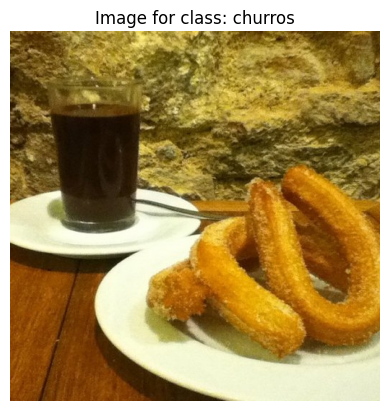

In [ ]:
!pip install torch torchvision tensorboard
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision pillow
!pip install matplotlib
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets transformers
!pip install evaluate

import os
import clip
import torch
import matplotlib.pyplot as plt

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
from torchvision.datasets import Food101
data = Food101(root=os.path.expanduser("~/.cache"), download=True, split = 'train')


# Prepare the inputs
image, class_id = data[4]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in data.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(3)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{data.classes[index]:>16s}: {100 * value.item():.2f}%")

plt.imshow(image)
plt.title(f"Image for class: {data.classes[class_id]}")
plt.axis('off')
plt.show()

## **Visualizing the guess**

In [ ]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [ ]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

def show_image_relevance(image_relevance, image, orig_image, title):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');
    axs[0].set_title(title)
    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');
    axs[1].set_title("heatmap")

from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)



Cloning into 'Transformer-MM-Explainability'...
remote: Enumerating objects: 1477, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 1477 (delta 89), reused 65 (delta 65), pack-reused 1359
Receiving objects: 100% (1477/1477), 29.00 MiB | 24.05 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [ ]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [ ]:
from torchvision.datasets import Food101
data = Food101(root=os.path.expanduser("~/.cache"), download=True, split = 'train')

tensor([0.0697, 0.9302], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,chur ros


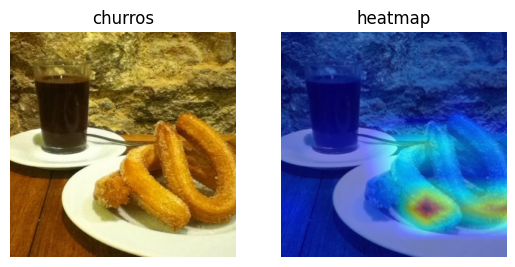

In [ ]:
image, texts = data[4]
img = preprocess(image).unsqueeze(0).to(device)
texts = data.classes[texts]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts, text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=image, title=texts)
  plt.show()


## **Version #3 Accuracy of CLIP on test set**

In [ ]:
import os
import clip
import torch
import matplotlib.pyplot as plt

# --- Use GPU if available (parallel computing) ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Loading CLIP ---
model, preprocess = clip.load('ViT-B/32', device)

# --- Transforming Images to fit the input size of CLIP ---
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),                                      # Resize Images to the input size of CLIP
    transforms.ToTensor(),                                              # Convert to tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize
    # Normalization is performed as (image - mean) / std
    # The values (0.485, 0.456, 0.406) and (0.229, 0.224, 0.225) are the standard means and standard deviations of
    # the ImageNet dataset, on which many pre-trained models, including CLIP, are often trained.
    # Using these values helps align our image data distribution with the one the CLIP model expects,
    # which is crucial for achieving accurate results.
    # CLIP Accuracy on Test Set: 68.56% w/out normalization, batch_size = 32
    # CLIP Accuracy on Test Set: 77.52% w/    normalization, batch_size = 32
    # CLIP Accuracy on Test Set: 77.55% w/    normalization, batch_size = 64
])

# Importing the Food101 dataset and applying the transformations to it
from torchvision.datasets import Food101
test_data = Food101(root=os.path.expanduser("~/.cache"), download=True, split='test', transform=preprocess)

# Loading the data in batches (No need to shuffle, since we are just testing in a zero-shot setting)
from torch.utils.data import DataLoader
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Prepare text inputs for all classes
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in test_data.classes]).to(device)
text_features = model.encode_text(text_inputs)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Initialize counters
correct_predictions = 0
total_images = 0

for images, labels in test_loader:
    # The images are already preprocessed and on the right device
    image_inputs = images.to(device)

    # Calculate image features
    with torch.no_grad():
        image_features = model.encode_image(image_inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Calculate similarity and predictions
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        predicted_indices = similarity.argmax(dim=1)

        # Update counters
        correct_predictions += (predicted_indices.cpu() == labels).sum().item()
        total_images += labels.size(0)

# Calculate accuracy
clip_accuracy = 100 * correct_predictions / total_images
print(f"CLIP Accuracy on Test Set: {clip_accuracy:.2f}%")

CLIP Accuracy on Test Set: 77.55%


# **Vision Transformer model:**
---

## **Training ViT**

In [ ]:
import datasets
from datasets import load_dataset
train_ds = load_dataset('food101', split="train")
validation_ds = load_dataset('food101', split="validation")

# need to exclude all of the dataset that is not RGB
exclude_idx = []
exclude_idx2 = []
for x in range(len(train_ds)):
  if train_ds[x]["image"].mode != 'RGB':
    exclude_idx.append(x)

for x in range(len(validation_ds)):
  if validation_ds[x]["image"].mode != 'RGB':
    exclude_idx2.append(x)

# create new dataset exluding those idx
train_ds_new = train_ds.select(
    (
        i for i in range(len(train_ds))
        if i not in set(exclude_idx)
    )
)

validation_ds_new = validation_ds.select(
    (
        i for i in range(len(validation_ds))
        if i not in set(exclude_idx2)
    )
)
ds = datasets.DatasetDict({"train":train_ds_new,"validation":validation_ds_new})




Parameter 'indices'=<generator object <genexpr> at 0x7ccf53b1ab90> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
#model_name_or_path = 'google/vit-large-patch16-224-in21k'
processor = ViTFeatureExtractor.from_pretrained(model_name_or_path)


def process_example(example_batch):

    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs


def transform(example_batch):
    # Taking a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')
    # Including the labels
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = ds.with_transform(transform)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }


In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-5-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="/content/drive/MyDrive/562_final/vit-food-v1",
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  num_train_epochs=30,
  logging_steps=10,
  learning_rate=2e-4,
  save_strategy="epoch",
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
train_results = trainer.train(resume_from_checkpoint = True)
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
8,0.319200,0.942110,0.798931
9,0.245200,1.006977,0.796198
10,0.049000,1.030490,0.804871
11,0.271500,1.097701,0.799525
12,0.163700,1.138585,0.802455


KeyboardInterrupt: ignored

In [ ]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.2501
  eval_loss               =     3.1002
  eval_runtime            = 0:19:40.12
  eval_samples_per_second =     21.396
  eval_steps_per_second   =      2.675


## **Using the model to guess a test image**

In [ ]:
model = ViTForImageClassification.from_pretrained(f"/content/drive/MyDrive/562_final/vit-food-v1/checkpoint-18940").to(device)

In [ ]:
ds["validation"][900]["image"]

In [ ]:

import timm

def get_prediction_probs(model, image, num_classes=3):
    # load the image
    img = image
    # preprocessing the image
    pixel_values = processor(img, return_tensors="pt")["pixel_values"].to(device)
    # perform inference
    output = model(pixel_values)
    # get the top k classes and probabilities
    probs, indices = torch.topk(output.logits.softmax(dim=1), k=num_classes)
    # get the class labels
    id2label = model.config.id2label
    classes = [id2label[idx.item()] for idx in indices[0]]
    # convert the probabilities to a list
    probs = probs.squeeze().tolist()
    # create a dictionary with the class names and probabilities
    results = dict(zip(classes, probs))
    return results

In [ ]:
get_prediction_probs(model, ds["validation"][900]["image"])